# Brianne Bell 
## ADS 509 Module 3: Group Comparison 
### January 23, 2023


The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji # needs to be 1.7 version
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [13]:
# Use this space for any additional import statements you need



In [31]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions

## Descriptive Stats Function
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    
    num_tokens = len(tokens) # number of tokens
    num_unique_tokens = len(set(tokens)) # number of unique tokens
    lexical_diversity = num_unique_tokens/num_tokens # unique/all=lexical diversity
    num_characters = sum(len(i) for i in tokens) # num characters
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print("\nThe top 5 most common tokens:\n") # {name} gives updated value
        print(Counter(tokens).most_common(5))
        
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])

## Emoji Function
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


## Removing Stop Tokens
def remove_stop(tokens) :
    # modify this function to remove stopwords
    return [i for i in tokens if i.lower() not in sw]


## Removing Punctiation (but not hashtags)
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))


## Tokenization Function with split on whitespace
def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    text = text.split(' ')
    return(text)


## Prepare Function
def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [53]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/breel.B-E-BELL/OneDrive/Documents/GitHub/ADS-509_M2-textmine-token-norm/"
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [54]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"
# checking
twitter_data.head(3)

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher


In [55]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)
# checking
twitter_data.tail(3)

,screen_name,name,id,location,followers_count,friends_count,description,artist
358369,RayRayRay27,Rachael :),19919217,Oldham,762,1479,A year to change a life is still a year ✨😌,robyn
358370,bhandberg,Ben Handberg,12642462,Sydney,432,593,Head of Consumer - Mango. Made in Melbourne. R...,robyn
358371,takemeback,Christine,15022058,New Jersey,182,260,"Stand for what is right, even if you stand alone.",robyn


In [56]:
# read in the lyrics here
path = "C:/Users/breel.B-E-BELL/OneDrive/Documents/GitHub/ADS-509_M2-textmine-token-norm/lyrics"
#initializing lists
artists = []
title = []
lyrics = []

# looping through the files
for artist in os.listdir(path):
    artist_name = os.path.join(path, artist)
    
    for file in os.listdir(artist_name):
        filename = os.path.join(path, artist, file)
        
        with open(filename) as infile:
            songs = infile.read().replace('\n', ' ') # remove \n
            songs.replace('\n', '')
            song_text = re.split(r'\s{3,}', songs) # making it so title can be separate from lyrics
        artists.append(artist)
        title.append(song_text[0])
        lyrics.append(''.join(song_text[1]))
        
        
lyrics_data = pd.DataFrame({'artist': artists,
                         'title': title,
                         'lyrics':lyrics})

#checking
lyrics_data.head(5)

,artist,title,lyrics
0,cher,"""88 Degrees""","Stuck in L.A., ain't got no friends And so Ho..."
1,cher,"""A Different Kind Of Love Song""",What if the world was crazy and I was sane Wou...
2,cher,"""After All""","Well, here we are again I guess it must be fat..."
3,cher,"""Again""",Again evening finds me at your door Here to a...
4,cher,"""Alfie""","What's it all about, Alfie? Is it just for the..."


In [57]:
# checking tail
lyrics_data.tail(5)

,artist,title,lyrics
415,robyn,"""We Dance To The Beat""",We dance to the beat We dance to the beat We d...
416,robyn,"""Where Did Our Love Go""",Thoughts about you and me Thinkin' about what...
417,robyn,"""Who's That Girl""",Good girls are pretty like all the time I'm ju...
418,robyn,"""With Every Heartbeat""",Maybe we could make it all right We could make...
419,robyn,"""You've Got That Something""",Look at me here I am I'm givin all of my lovin...


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [58]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare, pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare, pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [59]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [60]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
280621,cher,27| ♀️ | call me Haru | OC Artist| bi |♊ | Tak...,"[27, ♀️, , call, haru, , oc, artist, bi, ♊, , ..."
1635977,cher,Supercalifragilisticexpialidocious ✨,"[supercalifragilisticexpialidocious, ✨]"
803775,cher,🐾🐈🌎✌️ 🏳️‍🌈 #lesfic #newauthor #resist #voteblu...,"[🐾🐈🌎✌️, 🏳️‍🌈, #lesfic, #newauthor, #resist, #v..."
3547847,cher,"From Canada, part of #TWFanmily :) I love The ...","[canada, part, #twfanmily, , love, killers, br..."
3944981,cher,Lover of Golden furry beasts ❣️🐾❣️,"[lover, golden, furry, beasts, ❣️🐾❣️]"
1242355,cher,♥ @cfblsTVA @MarioTessier_ @voicezofficial @Da...,"[♥, cfblstva, mariotessier, voicezofficial, da..."
3890163,cher,AKA Cheri Bomb LeKohl | Miss Gay Tulsa USofA N...,"[aka, cheri, bomb, lekohl, , miss, gay, tulsa,..."
709483,cher,🌲🌲🌲🌲,[🌲🌲🌲🌲]
895963,cher,"Bleeding heart Libtard, Feminist, 💙Animals, Wr...","[bleeding, heart, libtard, feminist, 💙animals,..."
3336664,cher,(he/him) ♋️ business account ↠ @mycrystalearth,"[hehim, ♋️, business, account, ↠, mycrystalearth]"


With the data processed, we can now start work on the assignment questions. 

---

**Q:** What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

**A:** We could focus entirely on English words for the Twitter description instead of having a mix of other languages. It would help us (the users) understand terms better. Additionally, removal of nan descriptions or replacing nan with a blank space could prove beneficial. For the lyrics data I did go back and remove the '\n' values because they were bugging me. 

---

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [68]:
# function for helping calulate stats
def listing_out_coldata(list_of_lists):
    listed_words = [i for n in list_of_lists for i in n if i] # final if i is to remove blanks
    return listed_words

In [73]:
# setting it up
cher_lyrics_tokens_df = lyrics_data[lyrics_data['artist']=='cher']['tokens']
robyn_lyrics_tokens_df = lyrics_data[lyrics_data['artist']=='robyn']['tokens']

# making list of all tokens
cher_lyrics_tokens = listing_out_coldata(cher_lyrics_tokens_df)
robyn_lyrics_tokens = listing_out_coldata(robyn_lyrics_tokens_df)


In [74]:
print("\nLYRICS DESCRIPTIVE STATS:\n")

# calling function
print('\nCher Lyrics Descriptive Stats:\n')
descriptive_stats(cher_lyrics_tokens)

print('\nRobyn Lyrics Descriptive Stats:\n')
descriptive_stats(robyn_lyrics_tokens)


LYRICS DESCRIPTIVE STATS:


Cher Lyrics Descriptive Stats:

There are 31677 tokens in the data.
There are 3449 unique tokens in the data.
There are 152105 characters in the data.
The lexical diversity is 0.109 in the data.

The top 5 most common tokens:

[('love', 895), ('im', 471), ('know', 425), ('dont', 374), ('youre', 301)]

Robyn Lyrics Descriptive Stats:

There are 14939 tokens in the data.
There are 2128 unique tokens in the data.
There are 72536 characters in the data.
The lexical diversity is 0.142 in the data.

The top 5 most common tokens:

[('know', 304), ('im', 299), ('dont', 292), ('love', 269), ('got', 249)]


[14939, 2128, 0.14244594685052547, 72536]

---

**Q:** what observations do you make about these data? 

**A:** Both Cher and Robyn wrote a lot of love centered songs, with Cher having the word 'love' appearing more in her songs than Robyn did. They also share the words 'im', 'know', and 'dont' in their top five most common tokens. While Cher has 31,1667 tokens, only 3449 are unique so the lexical diversity is a bit lower than Robyn's when she has 14,939 (less than half) tokens and 2128 unique ones (diversity .142).  

---

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [76]:
# setting it up for twitter data
cher_twitter_tokens_df = twitter_data[twitter_data['artist']=='cher']['tokens']
robyn_twitter_tokens_df = twitter_data[twitter_data['artist']=='robyn']['tokens']

# making list of all tokens
cher_twitter_tokens = listing_out_coldata(cher_twitter_tokens_df)
robyn_twitter_tokens = listing_out_coldata(robyn_twitter_tokens_df)


In [78]:
# your code here

# function for getting concentration value
def concentration(tokens1_cher, tokens2_robyn):
    
    # size of each corpus
    corpus1_size = len(tokens1_cher)
    corpus2_size = len(tokens2_robyn)
    
    # output dictionaries set up:
        # need [word], [count of word], and [concentration of word]
    conc_dict1 = {'token': [], 'corpus_1_count':[], 'conc_1':[]}
    conc_dict2 = {'token': [], 'corpus_2_count':[], 'conc_2':[]}
    
    # overall count of tokens in each corpus to calc conc.
    count_corp1 = Counter(tokens1_cher)
    count_corp2 = Counter(tokens2_robyn)
    
    # looping through the corpus lists:
    for word in set(tokens1_cher):
        # adding in the cutoff of 5, as suggested
        if count_corp1[word] >= 5:
            conc_dict1['token'].append(word) # add in word
            conc_dict1['corpus_1_count'].append(count_corp1[word]) #add in count for that word
            conc_dict1['conc_1'].append(count_corp1[word]/corpus1_size) # count/size for conc.
            
    for word in set(tokens2_robyn):
        # adding in the cutoff of 5, as suggested
        if count_corp2[word] >= 5:
            conc_dict2['token'].append(word) # add in word
            conc_dict2['corpus_2_count'].append(count_corp2[word]) #add in count for that word
            conc_dict2['conc_2'].append(count_corp2[word]/corpus2_size) # count/size for conc.
            
            
    # making dataframe of results
    conc_1_df = pd.DataFrame(conc_dict1)
    conc_2_df = pd.DataFrame(conc_dict2)
    
    # combo dataframe, joined on token
    conc_df = conc_1_df.merge(conc_2_df, on= 'token')
    
    # making concentration ratio column
        # concentration ratio = conc1/conc2; rare words can go to infinity
    conc_df['ratio'] = conc_df['conc_1']/conc_df['conc_2']
    
    # ending function
    return conc_df


In [81]:
# running the above function <concentration>
## on twitter data; cher_twitter_tokens, robyn_twitter_tokens 
conc_twitter_df = concentration(cher_twitter_tokens, robyn_twitter_tokens)

# for Cher (corpus 1) vs. Robyn (top 10 highest ratio values)
conc_twitter_df.sort_values(by= 'ratio', ascending= False).head(10)

,token,corpus_1_count,conc_1,corpus_2_count,conc_2,ratio
11476,grandmother,7132,0.000404,19,0.000011,35.355865
15849,#fbr,3131,0.000177,12,0.000007,24.575681
14234,resister,1817,0.000103,7,0.000004,24.448973
20979,#resister,1276,0.000072,5,0.000003,24.037229
21022,nana,2010,0.000114,8,0.000005,23.665180
4151,rbsoul,1530,0.000087,7,0.000004,20.587192
7422,grandma,5705,0.000323,27,0.000016,19.901949
16950,#theresistance,3211,0.000182,16,0.000010,18.902709
2274,hiphoprap,2479,0.000140,13,0.000008,17.961264
12777,gop,1288,0.000073,7,0.000004,17.330918


In [82]:
# for Robyn (corpus 2) vs. Cher (top 10 lowest ratio values)
conc_twitter_df.sort_values(by= 'ratio').head(10)

,token,corpus_1_count,conc_1,corpus_2_count,conc_2,ratio
15322,vänner,5,2.830021e-07,138,0.000083,0.003413
4903,bäst,5,2.830021e-07,99,0.000059,0.004757
20354,sveriges,15,8.490062e-07,294,0.000177,0.004806
7442,träning,6,3.396025e-07,115,0.000069,0.004914
9670,brinner,7,3.962029e-07,131,0.000079,0.005033
7915,följ,12,6.792050e-07,221,0.000133,0.005114
16352,gärna,11,6.226046e-07,202,0.000121,0.005129
10058,arbetar,11,6.226046e-07,194,0.000117,0.005341
11023,varje,6,3.396025e-07,104,0.000062,0.005434
3601,familj,6,3.396025e-07,102,0.000061,0.005541


In [83]:
# running the above function <concentration>
## on twitter data; cher_lyrics_tokens, robyn_lyrics_tokens 
conc_lyrics_df = concentration(cher_lyrics_tokens, robyn_lyrics_tokens )

# for Cher (corpus 1) vs. Robyn (top 10 highest ratio values)
conc_lyrics_df.sort_values(by= 'ratio', ascending= False).head(10)

,token,corpus_1_count,conc_1,corpus_2_count,conc_2,ratio
19,walk,106,0.003346,5,0.000335,9.998005
148,find,121,0.003820,6,0.000402,9.510681
301,enough,116,0.003662,7,0.000469,7.815152
62,without,74,0.002336,5,0.000335,6.979739
113,strong,72,0.002273,5,0.000335,6.791098
317,man,171,0.005398,12,0.000803,6.720357
119,believe,133,0.004199,10,0.000669,6.272333
308,live,58,0.001831,5,0.000335,5.470606
125,tears,53,0.001673,5,0.000335,4.999002
136,name,50,0.001578,5,0.000335,4.716040


In [84]:
# for Robyn (corpus 2) vs. Cher (top 10 lowest ratio values)
conc_lyrics_df.sort_values(by= 'ratio').head(10)

,token,corpus_1_count,conc_1,corpus_2_count,conc_2,ratio
239,beat,17,0.000537,144,0.009639,0.055675
56,dance,23,0.000726,148,0.009907,0.073290
337,work,13,0.000410,75,0.005020,0.081745
253,hang,8,0.000253,35,0.002343,0.107795
15,shake,5,0.000158,18,0.001205,0.131001
141,pretend,5,0.000158,15,0.001004,0.157201
363,alright,10,0.000316,30,0.002008,0.157201
39,forgive,5,0.000158,15,0.001004,0.157201
27,known,6,0.000189,18,0.001205,0.157201
360,space,7,0.000221,20,0.001339,0.165061


---

**Q:** What are some observations about the top tokens? Do you notice any interesting items on the list? 

**A:** The lyrics data for the top 10 highest ratios of Cher to Robyn has a lot of similar words that I would describe as love song type words. At the opposite end (Robyn to Cher) the words seem less related to eachother. 
The twitter data (Cher to Robyn) has more hashtags and a few variations of grandmother, likely because Cher on the older side. Interestingly, Robyn vs Cher has a lot of foreign words that I am assuming are Swedish since that is where Robyn is from so it is arguable to say that maybe these common words are from common followers. 

---

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [85]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [90]:
# setting up the tokens dataframes
cher_twitter_tokens_df = pd.DataFrame(cher_twitter_tokens_df, columns= ['tokens'])
cher_lyrics_tokens_df = pd.DataFrame(cher_lyrics_tokens_df, columns= ['tokens'])

robyn_twitter_tokens_df = pd.DataFrame(robyn_twitter_tokens_df, columns= ['tokens'])
robyn_lyrics_tokens_df = pd.DataFrame(robyn_lyrics_tokens_df, columns= ['tokens'])
# running the count_words function (need df)

## twitter: cher_twitter_tokens_df, robyn_twitter_tokens_df 
cher_twitter_freq = count_words(cher_twitter_tokens_df)
robyn_twitter_freq = count_words(robyn_twitter_tokens_df)

## lyrics: cher_lyrics_tokens_df, robyn_lyrics_tokens_df
cher_lyrics_freq = count_words(cher_lyrics_tokens_df)
robyn_lyrics_freq = count_words(robyn_lyrics_tokens_df)

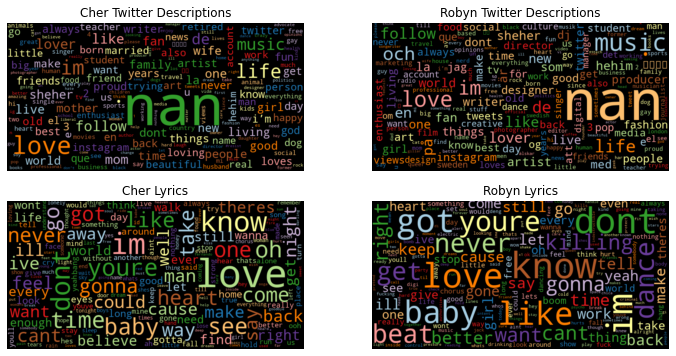

In [92]:
# plotting
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
wordcloud(cher_twitter_freq['freq'], title='Cher Twitter Descriptions')

plt.subplot(2, 2, 2)
wordcloud(robyn_twitter_freq['freq'], title='Robyn Twitter Descriptions')

plt.subplot(2, 2, 3)
wordcloud(cher_lyrics_freq['freq'], title='Cher Lyrics')

plt.subplot(2, 2, 4)
wordcloud(robyn_lyrics_freq['freq'], title='Robyn Lyrics')

---

**Q:** What observations do you have about these (relatively straightforward) wordclouds? 

**A:** The Twitter descriptions have a lot of empty fields, shown by the large 'nan' in the top two plots. They both also have 'love' and 'life' as common standing out words. The twitter descriptions have a lot of small, less common words filling the background, far more than the lyrics. 
The lyrics seem to have 'love' in common between the artists. Robyn seems to have more tokens that are highly common while Cher has more less common tokens. This is seen in the collection of larger font words in Robyn's plot compared to Cher's plot that has more medium to small words. 

---